# 3-D simulering av en stormsky

### Skrevet av Lasse Steinnes

## Introduksjon
Mektige skyformasjoner er blant de mest fascinerende naturfemonene i atmosfæren. Under riktige omstendigheter kan skyformasjonene bidra til uvær og utløse sterke krefter, med opprivende konsekvenser for biomer og lokalsamfunn. Med økende ekstremvær følger også større økonomiske kostnader. Av den grunn er det viktig å forstå prosessene i atmosfæren. 

Lynet er en en av de kraftigste naturkreftene en skyformasjon kan by på. Lyn fører til branner, og i enkelte tilfeller  dødsfall og alvorlige skader på mennesker og dyr. På ett sekund gir et lynnedsslag en strøm på 30 kA. Det er mye sammenlignet med de 0.5 A som strømmer gjennom en vanlig lyspære hjemme i stua. Likevel er lynformasjon i stormskyer et forløp man har lite kunnskap om sammenlignet med andre naturfenomen. 

I denne beregningsbaserte artikkelen ble det undersøkt under hvilke forhold lynet slår ned, og hvor langt unna det er trygt å stå fra et lynnedslag på ulik type sediment (gneiss og sandstein). 

## Teori

Dannelsen av en stormsky skjer i flere trinn. Først må fuktige luftmasser stige til en viss høyde og akkumulere volum. Dette kan skje på flere måter, som f.eks. at luftmassene presses opp langs sidene på en dal, eller at luft langs bakken varmes opp ved konveksjon, og stiger. 

Ettersom kumulusskyen vokser vil vertikale luftstrømmer oppstå på grunn av at de øvre skylagene oppsamler vann over lagringskapasitetet til skya. Vannet faller ned som hagl, samtig som små isskrystaller transporteres oppover. Med superkjølte vanndråper (-10 til -20 C) som katalyastor, gir kollisjoner utveksling av ladning. Positivt ladde iskrystaller samler seg i det øvre skylaget (ca. 10 km over havnivå) , der kulden (-40 C) hindrer videre utveksling av ladning. De negative ladningene samler seg opp i nedre skylag (6-8 km over havnivå), rett over positivt ladet p-region, som er med på å frigi de negative ladningene ved lynutslag.

Den modne Cumulonimbus-skyen er som regel 5-10 km i utstrekning vertikalt, og 6-10 km horisontal. Etthvert vil ladningsforskjellen i skya være så stor at en positivt ladet grunnskygge oppstår på bakken. Lynutslag skjer når spenningen er sterk nok til å gi et dielektrisk sammenbrudd i luften, som skjer ved et E-felt over (3*10^6 V/m). Når dette skjer kan en typisk tordensky gi lynnedslag hvert 20-30 sekund i en time.

I beregningene som følger modelleres skyen som en parallell-platekondenstar, som skaper et E-felt (Fig 1). Koden beregner E-felt en viss distanse fra skyen, og hvor langt unna man kan stå uten å bli skadet, når lynet slår ned. Koden kan brukes til å undersøke hva som skal til for at lynet skal slå ned i en viss høyde, og hva som skjer ved disse høydene ved ulik høyde på sky og ulik ladningstetthet i skylagene. Det er antatt at lynet ikke er inne i skylag, eller mellom skylag, men mellom skylaget og bakken. Det er i tillegg antatt lineært medium og beregningene er basert på teori knyttet til FYS1120-emnet ved UiO. 

![Fig1: Modell](modell1.png)
Fig 1: Modellen det ble arbeidet med. 

## Simulering av stormskyen og resultater

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

Først importeres biblioteker: numba, sympy, numpy, and matplotlib

Definerer konstanter: Dimensjonen til skyen,høyden, ladningen, og overflatene.

In [2]:
# Definere hvor skyen stopper og slutter i x-retningen [m]  
startx = -2500 
endx = 2500

# Det samme for z-retningen [m]  
startz = -2500
endz = 2500

# Bestemmer høyden for den negative og positive delene av skya [m]
negheight = 6000 
posheight = 10000
# belowground bestemmer direkte i utregning

# Bestem ladningen på oversida og nedsida av skya, og polarisering av bakken [C]
Q = -15 #Q is the total charge on the bottom (negative) part of the cloud
Q2 = 15 #Q2 is the total charge of the top (positive) part of the cloud
Q3 = 1.0001*10**(-1.4775)  #Q3 is total charge on the ground due to polarization 1e-11*10**(-1.478) 1500 m

k = 9e9 #Coulomb's constant


# ønsker å konstruere array med flere slike verdier, slik at E-feltet kan beregnes utover et grid, 
#slik kan man finne verdier der lynet kan slå ned

n = 100 # steps
x_pos = np.linspace(startx,endx,n)
z_pos = np.linspace(startz,endz,n)
x, z = np.meshgrid(x_pos,z_pos, indexing = 'ij')

#print(x[0]) # varierer x mellom -2500,og 2500
#print(z[0]) # holder z = -2500 konstant

y_pos = (x**2)/(10**4.5) - (z**2)/(10**4.5) + 1200 # Lager et dalføre


For å beregne E-feltet må skyen og ladningen på overflatene deles opp i et grid.

In [3]:
# Definerer hvor mange deler skyen skal deles opp i 
nx = 100
nz = 100 

# Definerer hvor stor hver del er
stepx = (endx - startx)/nx 
stepz = (endz - startz)/nz 

# Gjør om slik at ladningen blir fordelt på hver rute i grid
dQ = Q/(nx*nz) # Merk: denne vil få negativ verdi
dQ2 = Q2/(nx*nz) 
dQ3 = Q3/(nx*nz)
print('Ladningstetthet for overflaten er {:.2e} (øvre skylag), {:} (nedre skylag) og {:} (substrat)'.format(dQ,dQ2,dQ3))

Ladningstetthet for overflaten er -1.50e-03 (øvre skylag), 0.0015 (nedre skylag) og 3.3307606658497717e-06 (substrat)


E-feltet kan nå bestemmes ved å iterere over hver del, ved å initere E-feltet til å være null. Tre ulike metoder for å beregne E-feltet er nedenfor 1) For en variabel overflate (f.eks. dalføre) 2)For flatmark 3) For et observasjonspunkt. De to første programmene i dette settet gir en visuell oversikt over hvor lynet slår ned. 

[[-3.00001458e+06 -1.15466005e+05 -3.15074705e+04 ... -3.14796374e+04
  -1.15424265e+05 -2.29300858e+03]
 [-1.15454058e+05 -6.00517776e+04 -2.57788723e+04 ... -2.57485484e+04
  -6.00039558e+04 -2.31718852e+03]
 [-3.14835167e+04 -2.57668628e+04 -1.71023050e+04 ... -1.70703832e+04
  -2.57165460e+04 -2.33611697e+03]
 ...
 [-3.14559846e+04 -2.57366901e+04 -1.70703832e+04 ... -1.70401144e+04
  -2.56889082e+04 -2.31170765e+03]
 [-1.15412472e+05 -6.00039558e+04 -2.57284009e+04 ... -2.57006142e+04
  -5.99621972e+04 -2.28754194e+03]
 [-2.29300858e+03 -2.32897867e+03 -2.35975623e+03 ... -2.33505051e+03
  -2.29918124e+03 -2.25622467e+03]]


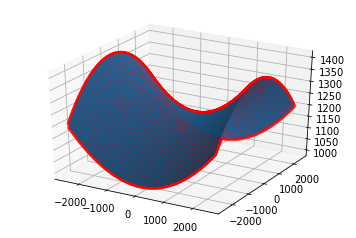

Fig2: Lynnedslag i et dalføre. Aksene i meter


In [4]:
# 1) For et dalføre 
# ønsker å vektorisere finne ut hvor det mest sannsynlig slår ned
E_arr = np.zeros((n,n))
lightning = -3*10**6

def efield():
    @jit(nopython=True)
    def efieldsum(m,p):
        efield = 0
        pos = np.array([x[m,p],y_pos[m,p],z[m,p]]) # høyde h
        for i in range(0,nx): #iterate over the x dimension of the cloud
            xloc = startx + i*stepx
            for j in range(0,nz): #iterate over the z dimension of the cloud
                zloc = startz + j*stepz

                posfield = k*dQ2/(np.linalg.norm(pos-np.array([xloc,posheight,zloc])))**2
                negfield = k*dQ/(np.linalg.norm(pos-np.array([xloc,negheight,zloc])))**2
                groundfield = -k*dQ3/(np.linalg.norm(pos-np.array([xloc,pos[1]-0.1,zloc])))**2
                efield = efield + negfield + posfield + groundfield
        return efield

    for m in range(n):
        for p in range(n):
            E_arr[m,p] = efieldsum(m,p)
    return E_arr

E_arr =  efield()
print(E_arr)


def plot_strikes():
    n = 100
    n2 = 9999
    E_strike = np.full((n,n),lightning)
    strike_points = np.greater(E_arr,E_strike)    # mulig jeg må bruke en for løkke gjennom E_arrays her
    strike_indices = np.where(strike_points == True)
    x_indices = strike_indices[0]
    z_indices = strike_indices[1]
    x_strike = x_pos[x_indices]
    z_strike = z_pos[z_indices]
    y_strike = (x_strike**2)/(10**4.5) - (z_strike**2)/(10**4.5) + 1200
    
    #print(len(x_strike),len(z_strike),len(y_scatter))
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(x_strike,z_strike,y_strike,color = 'red')
    ax.plot_surface(x, z, y_pos)
    plt.show()
    print('Fig2: Lynnedslag i et dalføre. Aksene i meter')

plot_strikes()


[[-2.99930939e+06 -1.14746602e+05 -3.07738744e+04 ... -3.07542697e+04
  -1.14713085e+05 -1.59602839e+03]
 [-1.14746602e+05 -5.93300167e+04 -2.50428257e+04 ... -2.50207653e+04
  -5.92904526e+04 -1.61797659e+03]
 [-3.07738744e+04 -2.50428257e+04 -1.63638916e+04 ... -1.63402673e+04
  -2.50008001e+04 -1.63475193e+03]
 ...
 [-3.07542697e+04 -2.50207653e+04 -1.63402673e+04 ... -1.63181873e+04
  -2.49811663e+04 -1.61816208e+03]
 [-1.14713085e+05 -5.92904526e+04 -2.50008001e+04 ... -2.49811663e+04
  -5.92568415e+04 -1.59629011e+03]
 [-1.59602839e+03 -1.61797659e+03 -1.63475193e+03 ... -1.61816208e+03
  -1.59629011e+03 -1.56734310e+03]]


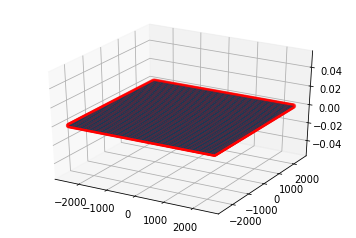

Fig3: Lynnedslag på flatmark. Aksene er i meter.


In [5]:
# 2) For flatmark
# ønsker å vektorisere finne ut hvor det mest sannsynlig slår ned.
E_arr = np.zeros((n,n)) # i x,z planet
efield = 0
h = 0
lightning = -3*10**6

def efield(h):
    @jit(nopython=True)
    def efieldsum(m,p):
        efield = 0
        pos = np.array([x[m,p],h,z[m,p]]) # høyde h
        for i in range(0,nx): #iterate over the x dimension of the cloud
            xloc = startx + i*stepx
            for j in range(0,nz): #iterate over the z dimension of the cloud
                zloc = startz + j*stepz

                posfield = k*dQ2/(np.linalg.norm(pos-np.array([xloc,posheight,zloc])))**2
                negfield = k*dQ/(np.linalg.norm(pos-np.array([xloc,negheight,zloc])))**2
                groundfield = -k*dQ3/(np.linalg.norm(pos-np.array([xloc,pos[1]-0.1,zloc])))**2
                efield = efield + negfield + posfield + groundfield
        return efield

    for m in range(n):
        for p in range(n):
            E_arr[m,p] = efieldsum(m,p)
    return E_arr

E_arr =  efield(h)
print(E_arr)

def plot_strikes():
    n = 100
    y = np.full((n,n),h)

    E_strike = np.full((n,n),lightning)
    strike_points = np.greater(E_arr,E_strike) 
    strike_indices = np.where(strike_points == True)
    x_indices = strike_indices[0]
    z_indices = strike_indices[1]
    x_strike = x_pos[x_indices]
    z_strike = z_pos[z_indices]
    
    n2 = len(x_strike)
    y_scatter =  np.full(n2,h)
    
    #print(len(x_strike),len(z_strike),len(y_scatter))
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(x_strike,z_strike,y_scatter,color = 'red')
    ax.plot_surface(x, z, y)
    plt.show()
    print('Fig3: Lynnedslag på flatmark. Aksene er i meter.')

plot_strikes()

In [6]:
### 3) For et observasjonspunkt
efield = 0
height = 0

pos = np.array([500,height,150])
for i in range(0,nx): #iterate over the x dimension of the cloud
    xloc = startx + i*stepx
    for j in range(0,nz): #iterate over the z dimension of the cloud
        zloc = startz + j*stepz

        negfield = k*dQ/(np.linalg.norm(pos-np.array([xloc,negheight,zloc])))**2
        posfield = k*dQ2/(np.linalg.norm(pos-np.array([xloc,posheight,zloc])))**2
        groundfield = -k*dQ3/(np.linalg.norm(pos-np.array([xloc,pos[1]-0.1,zloc])))**2
        efield = efield + negfield + posfield + groundfield

if efield < -3*10**6:
    print('Lyn!! E-felt verdi:{:}'.format(efield))

print("E-felt i observasjonspunktet er", efield, "N/C")



Lyn!! E-felt verdi:-3000077.93583371
E-felt i observasjonspunktet er -3000077.93583371 N/C


Videre ønskes det å beregne spenningen et punkt der lynet slår ned, slik at strømmen kan beregnes. Det er kjent at strømmen et lyn kan levere er 30kA, så hvilke resistans har lufta da, gitt at Ohms lov (V =RI) fortsatt gjelder? I beregningene er det benyttet at et lyn har diameter 2.5 cm og er en sylinder rett ned mot bakken. 

In [7]:
# gjør beregninger for V og I her gitt R = rho*l/A_tverrsnitt og (electrical breakdown of air 3 x 10^6)
# Da må man beregne integralet, dvs sum av E*dl, r = 2.5*10**-2 m /2 
# må la y variere mellom 1 og 5995 for å beregne potensialet (vil ikke dele på 0)
efield = 0
v_diff = 0

dl = (5999)/1000
for y in range(1,5999,1000):
    pos = np.array([0,y,0])
    dl = (5999)/1000
    for i in range(0,nx): #iterate over the x dimension of the cloud
        xloc = startx + i*stepx
        for j in range(0,nz): #iterate over the z dimension of the cloud
            zloc = startz + j*stepz
        
            negfield = k*dQ/(np.linalg.norm(pos-np.array([xloc,negheight,zloc])))**2        
            posfield = k*dQ2/(np.linalg.norm(pos-np.array([xloc,posheight,zloc])))**2
            groundfield = -k*dQ3/(np.linalg.norm(pos-np.array([xloc,pos[1]-0.1,zloc])))**2
            efield = efield + negfield + posfield + groundfield
            v_diff = -efield*dl
            
    
print("Spenningen er ", v_diff, "V")

obs_point = 0
# Strømmen som går gjennom er 
l = negheight - obs_point
a = (2.5*10**-2)/2 #[m]
A =  np.pi*a**2
rho = 1.3*10**(-3.65)
R = rho*l/A
I = v_diff/R
print('Det gir en strøm:',I,'A')
print('Resistiviteten i luft er vanligvis 10**9 til 10**15, men pga. varmen bryter partiklene i \
luften sammen til plasma, og resistivitet er da', rho,'ohm meter. Dette gir en konduktivitet',1/rho,'S/m')

#30,000 amperes (30 kA) kan lynet gi fra seg



Spenningen er  108303138.65897325 V
Det gir en strøm: 30445.025266765773 A
Resistiviteten i luft er vanligvis 10**9 til 10**15, men pga. varmen bryter partiklene i luften sammen til plasma, og resistivitet er da 0.0002910337480138842 ohm meter. Dette gir en konduktivitet 3436.0276319304853 S/m


Om man antar at strømmen spres jevnt utover overflaten til bakken, slik at Js = I/A_bakken, så vil dette gi E = Js/sigma, og integreres denne mhp dr, finner man et uttrykk for spenningen over bakken.

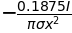

In [8]:
# dette spres til bakken og man kan beregne hvor langt unna man må stå for å være sikker.
# bruk konduktivitet
# Antar at Js = I/(pi*r**2) (I/A) sprer seg mest som en halvkule i bakken, 
# og at J = sigma*E, slik at E = J/sigma (1/sigma = rho)
# En spenning mellom bena (potensialforskjell) er 
# int_r ^(r+d) I/sigma*pi*r**2 dr 
sp.init_printing(use_unicode=False, wrap_line=False)
r = sp.Symbol('x')
sigma = sp.Symbol('sigma')
I = sp.Symbol('I')
pi = sp.Symbol('pi')
sp.integrate(I/(4/3*sigma*pi*r**3)/2,r) # som en disk



Følgende program undersøker hvordan spenningen blir i sediment med gneiss og sanstein, og beregner hvordan spenningen og strømmen gjennom kroppen til et menneske blir en gitt avstand fra lynnedslaget. Det antas at bakken nær nedslaget varmes opp, slik at konduktiviteten er lavere nær nedslaget, og at mye strøm går tapt direkte i nedslaget. Mer i sandstein enn gneis fordi sandstein har lavere ledningsevne. 

Siden bakken er ionisert antas at mest av strømmen spres utover langs overflaten av bakken. Før koden under kjøres, må I igjen defineres fra verdier av lynsylinderen (og ikke som symbol fra integrasjonen), så kjør den delen av koden om igjen.

In [11]:
steps = 1000
rmaks = 1250
r = np.linspace(0.5,rmaks,steps) # radius
d = 0.5 # meter mellom benene 
# kvarts,feltspat vanlig i gneis
# sandstein # kvart og feltspat, men bundet med leire

# litt mindre konduktivitet pga. vegetasjon osv.
ground = 0.3e-3

#gneiss
g_sigma100 = 20e-3 -ground
g_sigma20 = 80e-3 -ground

waist = 0.8 # m
legs_r = 0.13/2 # m

#sandstein
sigma100 = 0.5e-3 - ground # S/m til et spesielt rock  sandstein
sigma20 = 5e-3 - ground # til et annet  # varer ikke lenge, men rekker å varme opp litt

## strøm
ratio = (g_sigma100/sigma100)
#print(ratio)
I_gneiss = I/10
I_sandstein = I/ratio # strømmen er ikke likt fordelt i begge  J = I/A = I/pi*r**2, anta at strømmen er /20 i sandstein

def sigma(r,s20,s100):   # pga. varme  
    if  r < 3:
        s_val = s100
    else: 
        s_val = s20
    return s_val
        
# Dersom man ønsker kan man benytte denne koden til å beregne strømmen i et punkt langs bakken
def find_stream(I,rmax):
    Js = np.zeros(steps)
    for i in range(steps):
        #rho = 1/sigma(r[i],s20,s100)
        #R = r[i]/(2*np.pi*rmax*0.001)
        #Js[i] = V[i]/R
        Js[i] = I/(np.pi*rmax**2)
    return Js 

#  Beregner spenningen langs bakken
def evaluate_V(I,r,d,s20,s100,steps):
    V = np.zeros(steps)
    for i in range(steps):
        V[i] = 0.1875*I/(np.pi*sigma(r[i],s20,s100))*(1/r[i]**2 - 1/(r[i]+d)**2)
    return V

# gjennom kroppen så blir strømmen avhengig av spenningen
def find_streambody(V,waist,legs_r):
    I_body = np.zeros(steps)
    rho = 171e-2 #Ω/m til skjelettmuskler
    for i in range(steps):
        R = rho*waist/(np.pi*legs_r**2)     # R = rho*x/A # muskel # beregner strømmen som når mellomgulvet
        I_body[i] = V[i]/R
    return I_body

gneiss = evaluate_V(I_gneiss,r,d,g_sigma20,g_sigma100,steps)
sandstein = evaluate_V(I_sandstein,r,d,sigma20,sigma100,steps)

#print(gneiss)
#print(sandstein)

# Strømmen gjennom bakken og kropppen
stream_gneiss = find_stream(I_gneiss,rmaks)
stream_sandstein = find_stream(I_sandstein,rmaks)
streambody_gneiss = find_streambody(gneiss,waist,legs_r)
streambody_sandstein = find_streambody(sandstein,waist,legs_r)

# Visuliser grafer for spenningen mellom bena og strømmen det gir.
plt.figure(figsize = (10,6))

plt.subplot(121)
plt.plot(r,gneiss, label = 'Spenning gneiss (V)')
plt.plot(r,streambody_gneiss, label = 'Strøm gjennom kropp (gneiss) (A)')
plt.legend()
plt.axis([0,100,0,3*10**3])

plt.subplot(122)
plt.plot(r,sandstein, label = 'Spenning sandstein (V)')
plt.plot(r,streambody_sandstein, label = 'Strøm gjennom kropp (sandstein) (A)')
plt.legend()
plt.axis([0,100,0,3*10**4])
plt.xlabel('Avstand [m]')
plt.show()

print('Fig4: Strømmen gjennom kroppen, og spenningsforskjellen')
print('\n')
#print('Strømmen gjennom kroppen for gneiss som sediment')
#print(streambody_gneiss)
#print('\n')
#print('Strømmen gjennom kroppen for sandstein som sediment')
#print(streambody_sandstein)

TypeError: can't convert expression to float

Videre benyttes resultatene fra forrige program, og koden under beregner hvilken radius lynnedslaget vil gi et dødelig sjokk, som antas å være rundt 100e-3.

In [10]:
## Plott overflaten med radius og lyn
def radius_lethal(I,r):
    A_lethal = np.full(len(I),100e-3)
    lethal_points = np.less(I,A_lethal)
    lethal_indices = np.where(lethal_points == True)
    index = lethal_indices[0][0]
    return r[index]

rlethal_gneiss = radius_lethal(streambody_gneiss,r)
rlethal_sandstein = radius_lethal(streambody_sandstein,r)
    
def plot_lethal_strike(r_lethal):
    # for flaten bakken
    n = 100
    x_pos = np.linspace(-50,50,n)
    z_pos = np.linspace(-50,50,n)
    y1 = np.zeros((n,n))

    x, z = np.meshgrid(x_pos,z_pos, indexing = 'ij')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, z, y1,alpha = 1.0,color = 'cyan')
    
    # for skya
    x_pos = np.linspace(-30,30,n)
    z_pos = np.linspace(-30,30,n)
    y1 = np.full((n,n),negheight)

    x, z = np.meshgrid(x_pos,z_pos, indexing = 'ij')
    ax.plot_surface(x, z, y1,alpha = 0.4,color = 'grey')
    
    
    # for lynet
    cyl_a = 3
    x= np.linspace(0, cyl_a, 100)
    z= np.linspace(0, negheight, 100)
    Xcyl, Zcyl=np.meshgrid(x, z)
    Yc = np.sqrt(cyl_a**2-Xcyl**2)
    rstride = 20
    cstride = 10
    ax.plot_surface(Xcyl, Yc, Zcyl,alpha=0.7, color = 'yellow', rstride=rstride, cstride=cstride)
    ax.plot_surface(Xcyl, -Yc, Zcyl, alpha = 0.7, color ='yellow', rstride=rstride, cstride=cstride)
    

    # for dødelig radius
    groundheight = 0
    cyl_a = r_lethal
    
    rstride = 20
    cstride = 10
    
    R = np.linspace(0, cyl_a, 100)
    
    z = np.full((n,n),groundheight+1)
    u = np.linspace(0,  2*np.pi, 100)

    x = np.outer(R, np.cos(u))
    y = np.outer(R, np.sin(u)) 

    ax.plot_surface(x,y,z+2,alpha = 0.9, color ='red', rstride=rstride, cstride=cstride) # z in case of disk which is parallel to XY plane is constant and you can directly use h
    
    plt.show()

print('\n')
plot_lethal_strike(rlethal_gneiss)
print('Fig5: Dødelig radius for gneiss som sediment',rlethal_gneiss,'m')
print('\n')
plot_lethal_strike(rlethal_sandstein)
print('Fig 6: Dødelig radius for sandstein som sediment',rlethal_sandstein,'m')
print('Merk at aksene er i meter')

            

NameError: name 'streambody_gneiss' is not defined

## Diskusjon

Ved hjelp av en enkel parallellplatekondensator-modell for en stormsky, beregner programmet E-feltet fra skya, og spenningen feltet gir. Programmet kan benyttes til å undersøke hva som skal til for at det blir lynnedslag, og hvor langt unna det er trygt å stå fra nedslaget for å overleve. 

For at det skal lyne må spenningen overgå 3e6 V/m. Dette skjedde kun om bakken var polarisert, i samsvar med hvordan lyn oppstår i virkeligheten. Uten det ekstra bidraget til E-feltet, og dermed spenningen, blir det ikke lyn, og polariseringsstyrken i bakken er dermed bestemmende for hvor E-feltet blir sterkt nok (Test Q3 = 0 mot Q3 = 1e-1 f.eks). Siden E er proporsjonal med 1/r^2, blir E-feltet sterkere med høyde, slik at sannsynligheten for lyn, øker med høyden. Skyen er ikke uendelig i utstrekning, og har derfor ikke translasjonssymmetri. Et punkt midt under skya får mest bidrag fra hver E-feltet som oppstår fra hver del av skylaget i modellen. Dermed er det lurt å befinne seg i utkanten av skylaget, og helst utenfor, for å unngå lynet fullstendig.

Ifølge programmet blir resistiviteten i luft tilnærmet 2.9e-4 ohm/m idet lynet slår ned. Dette tilsvarer en konduktivitet tilnærmet 3.4e3, en tiendedel unna hva man ville forvente i plasma (1.6-2.2e4). Det antyder at fysikken ikke er helt lineær i dette tilfellet, men konduktiviteten er fortsatt skyhøy. Det er kjent at gassen i lufta omdannes til plasma ved ekstremt høye temperaturer, som for eksempel ved dielektrisk sammenbrudd. Temperaturen i lyn kan være opp mot 27 000 celsius, hele fem ganger varmere enn soloverflaten. Da eksisterer gassen i form av frie, ioniserte elementærpartikler, som gir en ekstremt god ledningsevne. En konsekvens er at strøm kan transporteres over store avstander. Resultatet samsvarer dermed med tidligere kunnskap.

Grunnet dårligere konduktivitet ble det antatt at mindre strøm fordeles over landoverflaten i sandstein enn gneiss. Det betyr at mindre strøm bidrar til spenningen som dannes i sedimentet. Imidlertid gir høyere resistivitet en større spenning mellom to punkter i sedimentet, fordi det er større ladningsforskjeller mellom punktene. Anta at en person står på bakken med en avtstand 0.5 meter mellom benene. Som følge av ladningsforskjellene blir strømmen opp til  mellomgulvet for personen større i sandstein på tross av mindre strøm. Dette gjenspeiler at i et materiale med lav konduktivitet, vil strømmen heller finne andre veier å gå, som for eksempel via huden på et menneske, eller enda mer skadelig; gjennom skjelettmusklene og indre organer. Den dødelige radius for sandstein blir dermed noe større enn for gneiss, som har høyere konduktivitet. 

24-30m ble dødsradiusen for materialene gitt at strømmen fordeles på overflaten. Det er ikke et dårlig anslag, da 10 meters avstand fra lynnedslag er kjent for å være dødelig, mens 20-30 meters avstand kan gi alvorlig skade. Dersom det hadde blitt antatt at strømmen ble fordelt nedover i bakken (som en halvkule), og ikke kun i overflaten, ville verdiene blitt 6.75 og 8.0 meter for henholdvis gneiss og sandstein (Det ser man om man setter Js = I/2V_halvkule). I en ekte grunn ville vegetasjon,luftlommer og urenhet i materialet hindret strømmen å spre seg ytterligere. Disse faktorene fanger modellen delvis opp.

Koden kan benyttes videre for å undersøke strømmen i andre materialer, eller eventuelt andre egenskaper ved stormskyer og lyn.  En utvidelse av programmet kunne f.eks. beregnet og visualisert B-feltet som strømmen gir opphav til.


## Takk

En takk rettes mot universitetet i Oslo som stiller med gode fasiliteter og ressurser. En spesiell takk til Tore Ole Odden (Postdoc, CCSE) ved fysisk institutt for hjelp med revidering og utforming av artikkelen.

## Litteratur
For mer informasjon om stormskyer og lyn kan du besøke noen av disse nettsidene
- Hvor langt unna det er trygt å stå fra lynet: https://www.canada.ca/en/environment-climate-change/services/lightning/safety/camping.html
- Mer om parallellkondensatormodellen: http://hyperphysics.phy-astr.gsu.edu/hbase/electric/lightning.html
- Litt om kostnaden ved klimaforandringer: https://unfccc.int/news/the-cost-of-climate-change
- Resistivitet i vev: https://www.ncbi.nlm.nih.gov/pubmed/10593226
- Konduktivitet og resistivitet til ulike steinformasjoner/sediment: https://em.geosci.xyz/content/physical_properties/electrical_conductivity/electrical_conductivity_values.html
- Dødelig strøm: https://www.physics.ohio-state.edu/~p616/safety/fatal_current.html
- Lynets dimensjoner: https://curiosity.com/topics/how-big-is-a-lightning-bolt/
- Feynman lektyre for de avanserte: http://www.feynmanlectures.caltech.edu/II_09.html
- Konduktivitet til lynindusert plasma :http://iopscience.iop.org/article/10.1088/0031-8949/80/03/035901/meta
- Formasjon av en tordensky: https://scied.ucar.edu/shortcontent/how-thunderstorms-form

Og følgende artikler gir et innblikk i noe av fysikken og forskningen som er benyttet:
- Michela Mariani, Andrés Holz, Thomas T. Veblen, Grant Williamson, Michael-Shawn Fletcher, David M. J. S. Bowman. Climate Change Amplifications of Climate-Fire Teleconnections in the Southern Hemisphere. Geophysical Research Letters, 2018; DOI: 10.1029/2018GL078294 
- The physics of lightning Joseph R.DwyeraMartin A.Umanb https://doi.org/10.1016/j.physrep.2013.09.004  




